In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

#hide code
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.patches as mpatches
np.random.seed(seed=1243)
dog_ears = np.random.normal(loc=2.5, scale=2.25, size=20)

cat_ears = np.random.normal(loc=6, scale=1.5, size=20)

cat_claws = np.random.normal(loc=5, scale=2, size=20)

dog_claws = np.random.normal(loc=3.5, scale=1.56, size=20)
animal_labels = np.concatenate((np.full((20, ), ['dog']),  np.full((20, ), ['cat'])))


characteristic_df = pd.DataFrame({'claw sharpness': np.concatenate((dog_claws, cat_claws)),
              'ear pointiness': np.concatenate((dog_ears, cat_ears)), 'Label': animal_labels})
characteristic_df = characteristic_df.sample(frac=1).reset_index(drop=True)
cat_df = characteristic_df.loc[characteristic_df.Label =='cat']
dog_df = characteristic_df.loc[characteristic_df.Label =='dog']

# K-Nearest Neighbor (kNN)

Extending the idea from one neighbor to multiple, we can classify a new point based on the k- nearest neighbors instead of just relying on one. This algorithm uses information about a data point's k nearest neighbors to classify this new data point. You may be wondering how to choose k, and what does *near* mean? These are parameters of this algorithm that can be modified dependent on the problem and are discussed in more detail in [Section 21.3: Features to Consider.](../../21/3/Features_to_Consider.ipynb)
The basic structure of the algorithm is outlined below:

Given a collection of labeled data points, $\mathcal{D} = \{(x,y)_i\}_{i=1}^n$, a value for $k$, and a distance metric, $d(p,q)$ we classify a new data point $z$ in the following way:
1. Calculate the distance $d(p,z)$ for each point $p$ in the dataset
2. Find the $k$ smallest values of $d(p,z)$
3. Classify $z$ dependent on the mode, or most often, classification of it's $k$ nearest neighbors.


We explore the same example from the previous section where we have characteristics of dogs and cats and want to classify a new point $(5.8,4.9)$. We said one neighbor might not give us an accurate representation, so we consider more neighbors.

In [2]:
characteristic_df.head()

,claw sharpness,ear pointiness,Label
0,3.825685,6.406667,cat
1,4.763658,1.951387,dog
2,6.329188,5.066956,cat
3,2.824689,1.649148,dog
4,5.949133,4.280015,cat


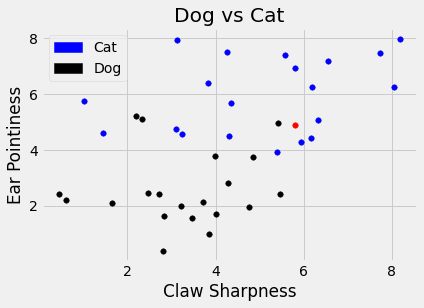

In [3]:
plt.scatter(cat_df['claw sharpness'], cat_df['ear pointiness'] , color='blue', s=30)
plt.scatter(dog_df['claw sharpness'], dog_df['ear pointiness'] , color='black', s=30);
plt.scatter(5.8,4.9 , color='red', s=30);

blue_patch = mpatches.Patch(color='blue', label='Cat')
black_patch = mpatches.Patch(color='black', label='Dog')
plt.legend(handles=[blue_patch, black_patch])

plt.title("Dog vs Cat")
plt.ylabel('Ear Pointiness')
plt.xlabel('Claw Sharpness');

We can build on the idea from the previous section to create a function that returns the closest $k$ neighbors of a given point of interest. To do this, we need our `distance` function and `row_wise_distance` from the previous section. Note `distance` computes the Euclidean distance, while `row_wise_distance` takes every point in a given DataFrame and elementwise computes the distance between the new point.

In [4]:
# the Euclidean distance
def distance(pt1, pt2):   
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def row_wise_distance(row, my_point):
    '''Computes the distance between the given my_point and a single df row'''
    return distance(my_point, np.array(row))

With these functions we can build a function that sorts distances and find the given $k$ closest points.

In [5]:
def closest_k(df, point, k):
    """Outputs a df containing the k closest rows in the input df to array 'point' """
    df = df.assign(Distance_to_point = df.apply(row_wise_distance, args=(point,), axis=1))
    df = df.sort_values('Distance_to_point') 
    topk = df.head(k)
    return topk

We also want to read from this DataFrame the majority. To do this, it will be easier to encode the labels of 'cat' and 'dog' as numerical values. So we create a new column with 0 for cat and 1 for dog.

In [6]:
def convert_bool(input_label):
    '''Converts to numerical encoding'''
    if input_label == 'dog':
        return 1
    else: 
        return 0

characteristic_df['Class'] = characteristic_df['Label'].apply(convert_bool)
characteristic_df.head()

,claw sharpness,ear pointiness,Label,Class
0,3.825685,6.406667,cat,0
1,4.763658,1.951387,dog,1
2,6.329188,5.066956,cat,0
3,2.824689,1.649148,dog,1
4,5.949133,4.280015,cat,0


Then we can find the majority category that is closest to the new point. The function below counts the number of labels in each class and compares to find the larger option.

In [7]:
def majority(topkclasses):
    """1 if the majority of the "Class" column is 1's, and 0 otherwise."""
    ones = topkclasses[topkclasses.Class==1].shape[0]
    zeros = topkclasses[topkclasses.Class==0].shape[0]
    if ones > zeros:
        return 1
    else:
        return 0

Putting these functions together we input our feature DataFrame, the new point we want to classify, and the number of neighbors we are interested in, to get a sorted DataFrame. Here we choose $k=5$. (Please see [Section 21.4: Multiple Classes.](../../21/4/Multiple_Classes.ipynb) for an exploration into how to choose $k$). Then we use the `majority` function to count the majority class within the $k$ closest neighbors.

In [8]:
top_k = closest_k(characteristic_df[['claw sharpness', 'ear pointiness']], point = np.array([5.8,4.9]), k = 5)
top_k.join(characteristic_df['Class'])

,claw sharpness,ear pointiness,Distance_to_point,Class
24,5.422290,4.963878,0.383073,1
2,6.329188,5.066956,0.554901,0
12,6.168168,4.426849,0.599516,0
4,5.949133,4.280015,0.637670,0
7,5.385259,3.926157,1.058480,0


In [9]:
majority(top_k.join(characteristic_df['Class']))

0

We see the majority of the class labels for the 5 closest neighbors is 0: 'cat'. Therefore we label this new point as 'cat'. See below for a visualization. 

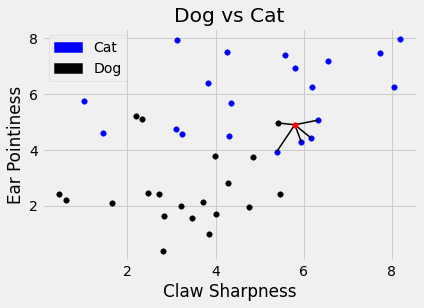

In [10]:
import matplotlib.patches as mpatches
plt.scatter(cat_df['claw sharpness'], cat_df['ear pointiness'] , color='blue', s=30)
plt.scatter(dog_df['claw sharpness'], dog_df['ear pointiness'] , color='black', s=30);

plt.plot((top_k['claw sharpness'].iloc[0], 5.8),(top_k['ear pointiness'].iloc[0],4.9),'black', linewidth=1.5,zorder = 1);
plt.plot((top_k['claw sharpness'].iloc[1], 5.8),(top_k['ear pointiness'].iloc[1],4.9),'black', linewidth=1.5,zorder = 1);
plt.plot((top_k['claw sharpness'].iloc[2], 5.8),(top_k['ear pointiness'].iloc[2],4.9),'black', linewidth=1.5, zorder = 1);
plt.plot((top_k['claw sharpness'].iloc[3], 5.8),(top_k['ear pointiness'].iloc[3],4.9),'black', linewidth=1.5, zorder = 1);
plt.plot((top_k['claw sharpness'].iloc[4], 5.8),(top_k['ear pointiness'].iloc[4],4.9),'black', linewidth=1.5, zorder = 1);


plt.scatter(5.8,4.9, color='red', s=30);
#plt.legend(["cat" , "dog"])
blue_patch = mpatches.Patch(color='blue', label='Cat')
black_patch = mpatches.Patch(color='black', label='Dog')
plt.legend(handles=[blue_patch, black_patch])
#plots.axis('equal');
plt.title("Dog vs Cat")
plt.ylabel('Ear Pointiness')
plt.xlabel('Claw Sharpness');

This is the general idea for kNN classification, but there are some questions that still remain. For the example above, when we chose k = 1 we got a different classification than k = 5. **How do we choose a value for k in a general classification problem?** Additionally, we might wonder **Is there a sense of accuracy for this algorithm?** In other words, how can we measure how well this classification algorithm actually classifies new data? And what about the data itself? **How can we standardize the data so that, regardless of units, we get the same classification?**

All of these questions are investigated in the next two sections.